In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
#Simple CNN

class CNN(nn.Module):
    
    def __init__(self , in_channels , num_classes ):
        super(CNN , self).__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels , out_channels = 8 , kernel_size = 3 , stride = 1 , padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = (2, 2) , stride = (2,2))
        self.conv2 = nn.Conv2d(in_channels = 8 , out_channels = 16, kernel_size = 3, stride = 1 , padding = 1 )
        self.fc1 = nn.Linear(16*7*7 ,num_classes)
        
    def forward(self , x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.reshape(x.shape[0] , -1)
        x = self.fc1(x)
        
        return x 
        

        

In [3]:
#Setting Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' ) 

In [4]:
#Hyperparameters
learning_rate = 0.001
in_channels = 1
num_classes = 10
batch_size= 64
num_epochs = 5

In [5]:
# Loading Data


train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 224172537.08it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 57711145.22it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69166522.28it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7462016.75it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [6]:
model = CNN(in_channels = in_channels , num_classes = num_classes)
model.to(device)


CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [7]:
#loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() ,lr= learning_rate , weight_decay = 0.0)

In [8]:

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    model.train()  # Set the model to train mode
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Getting data
        data = data.to(device)
        targets = targets.to(device)
        
        # Forward
        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item() * data.size(0)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculating training accuracy
        _, pred = scores.max(1)
        train_correct += pred.eq(targets).sum().item()
        train_total += data.size(0)
        
    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    
    # Evaluation on the test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = data.to(device)
            targets = targets.to(device)
            
            # Forward
            scores = model(data)
            loss = criterion(scores, targets)
            test_loss += loss.item() * data.size(0)
            
            # Calculating test accuracy
            _, pred = scores.max(1)
            test_correct += pred.eq(targets).sum().item()
            test_total += data.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = test_correct / test_total
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)
    
    # Print the progress
    print("Epoch: {}  Train Loss: {:.4f}  Train Accuracy: {:.4f}  Test Loss: {:.4f}  Test Accuracy: {:.4f}".format(
        epoch, train_loss, train_accuracy, test_loss, test_accuracy))


Epoch: 0  Train Loss: 0.3264  Train Accuracy: 0.9042  Test Loss: 0.0993  Test Accuracy: 0.9698
Epoch: 1  Train Loss: 0.0937  Train Accuracy: 0.9722  Test Loss: 0.0664  Test Accuracy: 0.9780
Epoch: 2  Train Loss: 0.0706  Train Accuracy: 0.9789  Test Loss: 0.0533  Test Accuracy: 0.9819
Epoch: 3  Train Loss: 0.0599  Train Accuracy: 0.9820  Test Loss: 0.0575  Test Accuracy: 0.9813
Epoch: 4  Train Loss: 0.0519  Train Accuracy: 0.9844  Test Loss: 0.0475  Test Accuracy: 0.9833


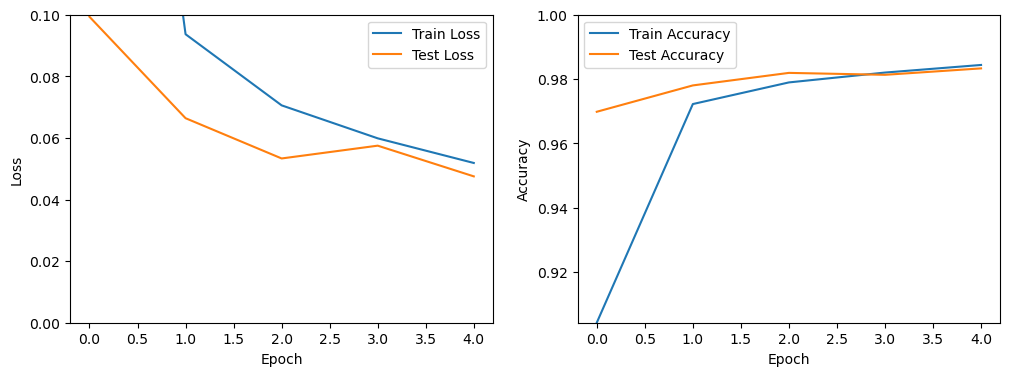

In [9]:
# Plotting the loss and accuracy graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 0.1])  # Set the y-axis range based on the maximum loss value


plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([min(min(train_accs), min(test_accs)), 1])  # Set the y-axis range based on the minimum accuracy value


plt.show()
